### Weekly Demand Data (train.csv):

- **id**: Unique ID assigned to each entry
- **week**: Week number for the recorded data
- **center_id**: Unique ID for the fulfillment center
- **meal_id**: Unique ID for the meal served
- **checkout_price**: Final price of the meal, including discounts and charges
- **base_price**: Initial price of the meal
- **emailer_for_promotion**: Indicates whether an emailer was sent for promotion
- **homepage_featured**: Indicates if the meal was featured on the homepage
- **num_orders**: Target variable - Count of orders for the meal

### Fulfillment Center Information (fulfilment_center_info.csv):

- **center_id**: Unique ID for the fulfillment center
- **city_code**: Unique code for the city where the center is located
- **region_code**: Unique code for the region
- **center_type**: Anonymized type of the center
- **op_area**: Operational area of the center (in km^2)

### Meal Information (meal_info.csv):

- **meal_id**: Unique ID for the meal
- **category**: Category of the meal (e.g., beverages, snacks, soups)
- **cuisine**: Cuisine type of the meal (e.g., Indian, Italian)


In [146]:
import sys
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit modules
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Extreme Gradient Boost Module
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Needed to export the trained model
import pickle

# Ignore printing warnings for general readability
warnings.filterwarnings("ignore")

# Install or upgrade required packages
# packages_to_install = ['xgboost', 'scikit-learn']
# for package in packages_to_install:
#     !{sys.executable} -m pip install --upgrade {package}

# To build model for prediction
def build_model(estimator, parameters, X_train, y_train):
    model = GridSearchCV(estimator, parameters, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2


# Load the datasets

In [147]:
center_info = pd.read_csv('./data/fulfilment_center_info.csv')
meal_info = pd.read_csv('./data/meal_info.csv')
test_data = pd.read_csv('./data/test.csv')
train_data = pd.read_csv('./data/train.csv')

In [148]:
train_data

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [149]:
# Summary statistics
print("\nSummary Statistics for Train Data:")
train_data.describe()


Summary Statistics for Train Data:


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [150]:
train_data = train_data.drop("center_id", axis=1)
test_data = test_data.drop("center_id", axis=1)
data = train_data
# Merge data with meal_info
data = pd.merge(data, meal_info, how='inner', on='meal_id').sort_values(by=['week'])
data

,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,1885,136.83,152.29,0,0,177,Beverages,Thai
127961,1348802,1,2290,291.97,293.97,0,0,473,Rice Bowl,Indian
127960,1032714,1,2290,298.82,297.82,0,0,649,Rice Bowl,Indian
127959,1393227,1,2290,297.82,296.82,0,0,325,Rice Bowl,Indian
127958,1044078,1,2290,301.73,299.73,0,0,419,Rice Bowl,Indian
...,...,...,...,...,...,...,...,...,...,...
427605,1480468,145,2664,242.53,306.52,0,1,837,Salad,Italian
427604,1379816,145,2664,251.23,337.62,0,0,312,Salad,Italian
427603,1119335,145,2664,242.53,338.56,0,0,676,Salad,Italian
427601,1181368,145,2664,242.53,338.56,0,0,215,Salad,Italian


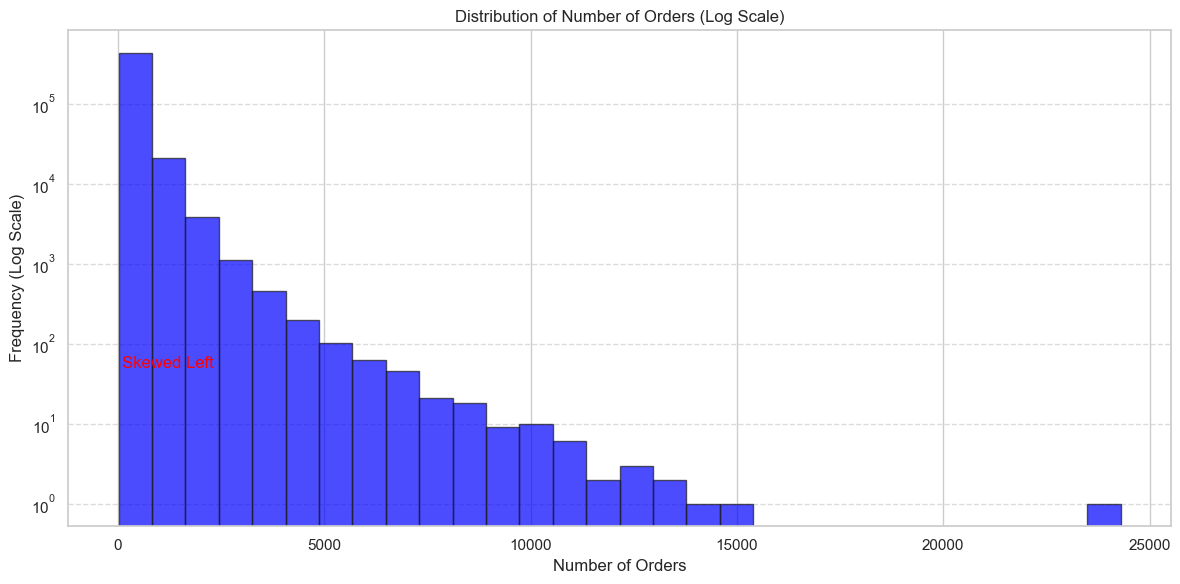

In [151]:
# Enhanced distribution plot with logarithmic y-axis scale
plt.figure(figsize=(12, 6))

# Apply logarithmic scale to the y-axis for handling skewness
plt.hist(train_data['num_orders'], bins=30, edgecolor='k', alpha=0.7, color='blue')
plt.yscale('log')  # Apply logarithmic scale to y-axis

plt.xlabel('Number of Orders')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Number of Orders (Log Scale)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines for better readability

# Add annotations for skewness information
plt.annotate('Skewed Left', xy=(100, 50), fontsize=12, color='red')

plt.tight_layout()
plt.show()

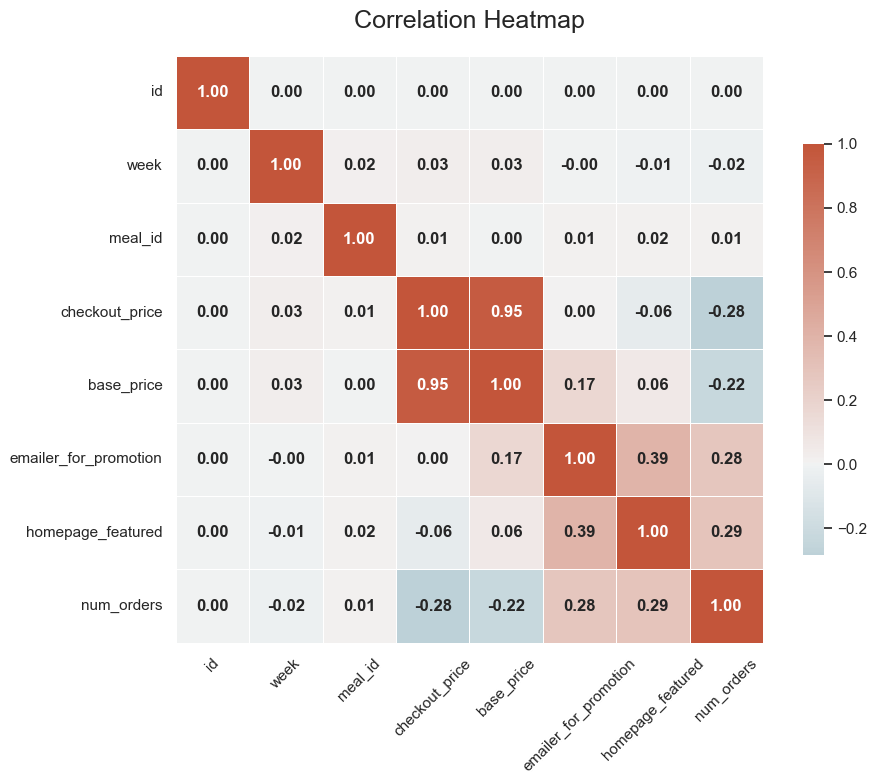

In [152]:
# Correlation heatmap
correlation_matrix = train_data.corr()

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")  # Set style with white grid background

# Define a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the heatmap with more visual enhancements
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0,
            linewidths=.5, cbar_kws={"shrink": 0.7}, square=True,
            annot_kws={"size": 12, "weight": "bold"})  # Customize annotation style

# Add title and adjust layout
plt.title('Correlation Heatmap', fontsize=18, pad=20)  # Add padding to title
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.tight_layout()
plt.show()

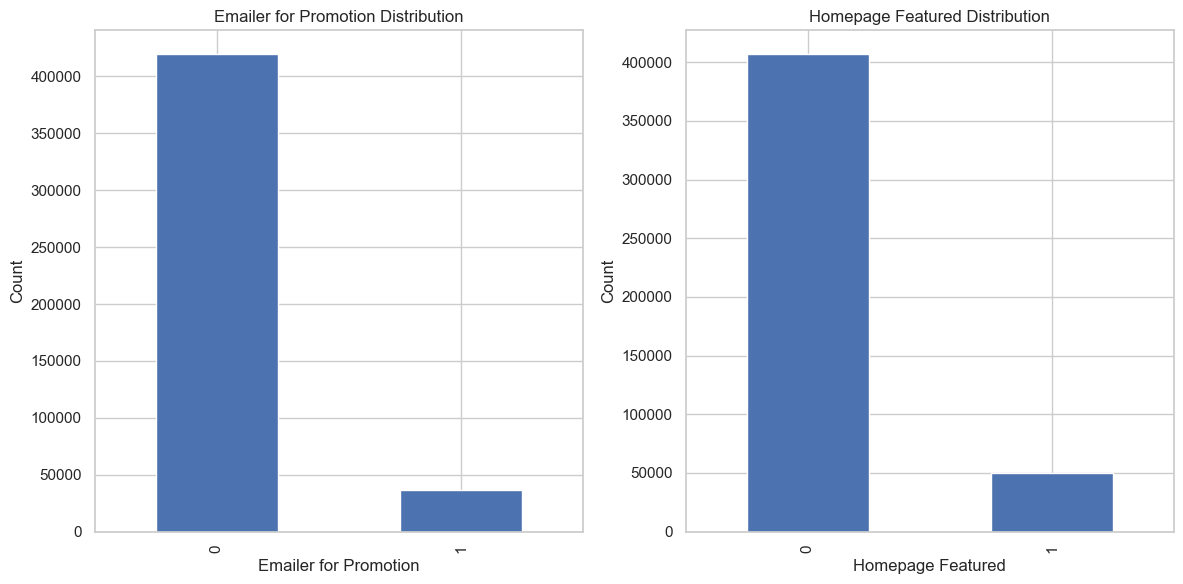

In [153]:
# Explore categorical variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_data['emailer_for_promotion'].value_counts().plot(kind='bar')
plt.xlabel('Emailer for Promotion')
plt.ylabel('Count')
plt.title('Emailer for Promotion Distribution')

plt.subplot(1, 2, 2)
train_data['homepage_featured'].value_counts().plot(kind='bar')
plt.xlabel('Homepage Featured')
plt.ylabel('Count')
plt.title('Homepage Featured Distribution')
plt.tight_layout()
plt.show()

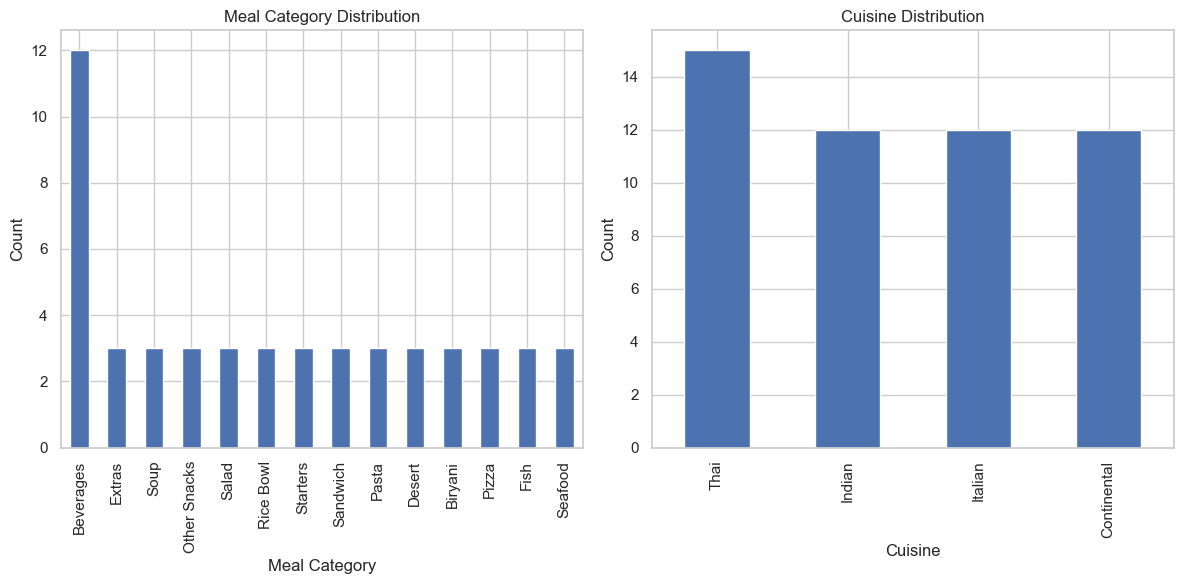

In [154]:
# Explore meal categories and cuisines
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
meal_info['category'].value_counts().plot(kind='bar')
plt.xlabel('Meal Category')
plt.ylabel('Count')
plt.title('Meal Category Distribution')

plt.subplot(1, 2, 2)
meal_info['cuisine'].value_counts().plot(kind='bar')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.title('Cuisine Distribution')
plt.tight_layout()
plt.show()

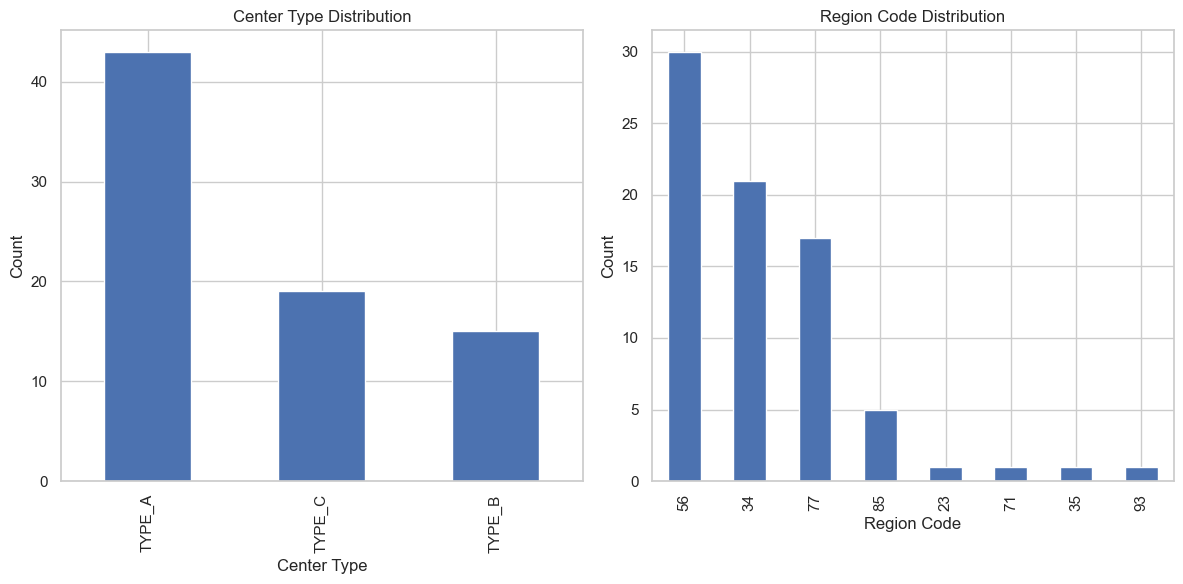

In [155]:
# Explore center types and regions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
center_info['center_type'].value_counts().plot(kind='bar')
plt.xlabel('Center Type')
plt.ylabel('Count')
plt.title('Center Type Distribution')

plt.subplot(1, 2, 2)
center_info['region_code'].value_counts().plot(kind='bar')
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.title('Region Code Distribution')
plt.tight_layout()
plt.show()

In [156]:
meal_info.nunique()

meal_id     51
category    14
cuisine      4
dtype: int64

For our ML part, I things that column ID is useless because it is just a random number it doesn't give us any real informaion concerning our business.

In [157]:
data_ = data.drop('id', axis= 1) 
data_.shape

(456548, 9)

In our dataframe data_, we have 3 categorical values we need to encode those.

In [158]:
df = pd.get_dummies(data_)
df.shape

(456548, 25)

In [159]:
X = df.drop('num_orders', axis= 1)
y = df['num_orders']

In [160]:
# Split the data into training & testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

#  Model Selection

The selection of XGBoost (Extreme Gradient Boosting) was based on its superior performance compared to Linear Regression and Random Forest models. XGBoost achieved a lower Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) values, indicating better predictive accuracy. Despite having a reasonable training time of 9.20 seconds, which is longer than Linear Regression but significantly faster than Random Forest, XGBoost's balance between accuracy and computational efficiency made it the preferred choice for the task.

In [161]:
# Define the models along with their configurations in a dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
}

results_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'Training Time'])

# Function to fit, predict, and evaluate a model
def evaluate_model(name, model):
    pipeline = Pipeline([
        ('scaling', StandardScaler()),  # Uncomment if scaling is needed
        (name, model)
    ])

    start_time = time.time()
    pipeline.fit(X_train_full, y_train_full)
    elapsed_time = time.time() - start_time

    y_test_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)

    return pd.Series({'Model': name, 'MSE': mse, 'RMSE': rmse, 'Training Time': elapsed_time})

# Iterate through models and evaluate
for name, model in models.items():
    result = evaluate_model(name, model)
    results_df = results_df.append(result, ignore_index=True)

results_df

,Model,MSE,RMSE,Training Time
0,Linear Regression,99769.921826,315.863771,0.686040
1,Random Forest,56418.822261,237.526466,70.627885
2,XGBoost,51948.523434,227.922187,21.510135


# Hyperparameter tunning

Based on the output, the XGBoost and Random Forest models have lower MSE and RMSE values compared to Linear Regression, which suggests that they are performing better on the data. Additionally, XGBoost has the lowest RMSE among the models, indicating that it's making more accurate predictions. However, it's important to consider other factors such as model complexity, interpretability, and potential overfitting when selecting the best model for your specific problem. Nevertheless, Hyperparameter tuning can help address some of these factors.

In [162]:
# Define the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('xgboost', XGBRegressor(objective='reg:linear', random_state=42, n_jobs=-1))
])

# Define a more restricted hyperparameter search space
param_dist = {
    'xgboost__max_depth': np.arange(5, 11),
    'xgboost__n_estimators': np.arange(10, 51, 10),
    'xgboost__learning_rate': [0.1, 0.01]
}

# Create RandomizedSearchCV object with fewer iterations
rs_xgb = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, n_iter=20)

# Fit the RandomizedSearchCV
start_time = time.time()
rs_xgb.fit(X_train_full, y_train_full)
elapsed_time = time.time() - start_time

# Print the best hyperparameters
best_params = rs_xgb.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
xgb_tuned = rs_xgb.best_estimator_

# Fit the best estimator to the training data
start_time = time.time()
xgb_tuned.fit(X_train_full, y_train_full)
fit_time = time.time() - start_time

# Make predictions on the test data
predictions = xgb_tuned.predict(X_test)

# Calculate mean squared error on the test data
mse_test = mean_squared_error(y_test, predictions)

# Display results
print(f"RandomizedSearchCV Time: {elapsed_time:.2f} seconds")
print(f"Best Estimator Fit Time: {fit_time:.2f} seconds")
print(f"Mean Squared Error on Test Data: {mse_test:.4f}")

[03:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Best Hyperparameters: {'xgboost__n_estimators': 40, 'xgboost__max_depth': 9, 'xgboost__learning_rate': 0.1}
[03:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RandomizedSearchCV Time: 318.11 seconds
Best Estimator Fit Time: 13.41 seconds
Mean Squared Error on Test Data: 54024.8725


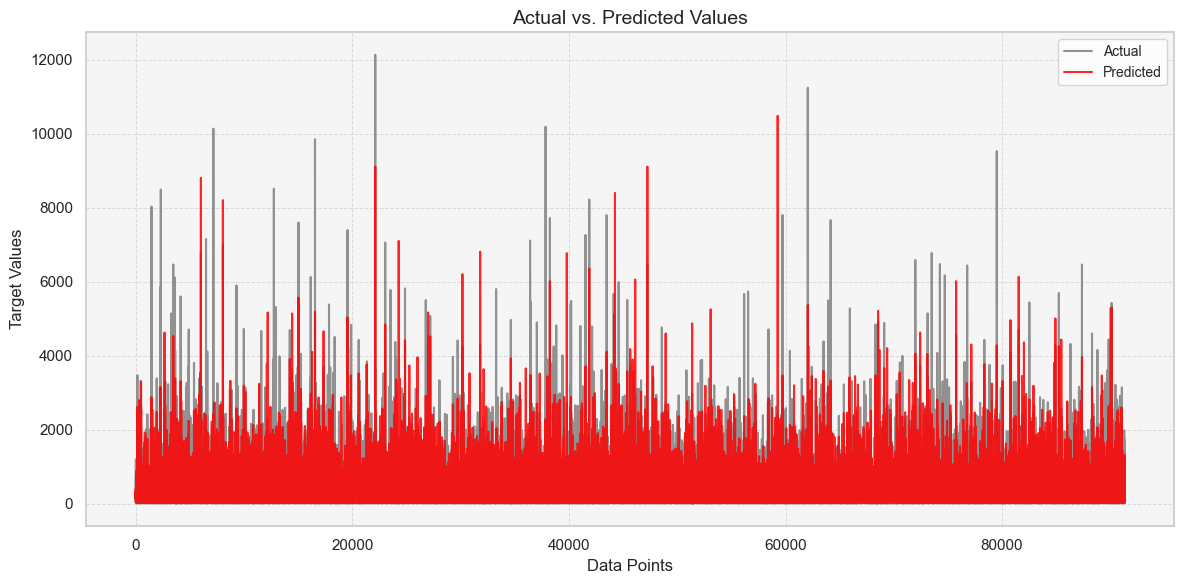

In [166]:
# Set custom color palette
actual_color = 'gray'
predicted_color = 'red'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual vs. predicted values
ax.plot(range(len(y_test)),y_test, label="Actual", color=actual_color, alpha=0.85)
ax.plot(range(len(predictions)),predictions, label="Predicted", color=predicted_color, alpha=0.85)

# Customize plot appearance
ax.set_xlabel('Data Points', fontsize=12)
ax.set_ylabel('Target Values', fontsize=12)
ax.set_title('Actual vs. Predicted Values', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Add a subtle background color
ax.set_facecolor('whitesmoke')

# Fine-tune layout
plt.tight_layout()

# Show the plot
plt.show()

# Features importance

[03:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model Fit Time: 32.68 seconds
Mean Squared Error on Test Data: 52118.1626


<Figure size 1000x600 with 0 Axes>

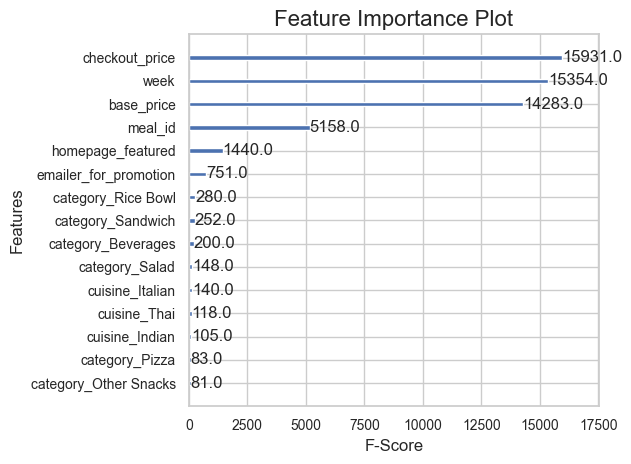

In [135]:
# Define the XGBoost model with selected hyperparameters
model = XGBRegressor(
    objective="reg:linear",
    max_depth=10,
    booster='gbtree',
    random_state=42,
    n_jobs=-1
)

# Train the model
start_time = time.time()
model.fit(X_train_full, y_train_full)
fit_time = time.time() - start_time

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate mean squared error on the test data
mse_test = mean_squared_error(y_test, y_test_pred)

# Display results
print(f"Model Fit Time: {fit_time:.2f} seconds")
print(f"Mean Squared Error on Test Data: {mse_test:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=15)
plt.title('Feature Importance Plot', fontsize=16)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Predictions

In [136]:
# Select relevant columns for training
columns_to_keep = ['id', 'week', 'meal_id', 'checkout_price', 'base_price',
                   'emailer_for_promotion', 'homepage_featured', 'num_orders']

training_data = data.loc[:,columns_to_keep]

# Drop 'num_orders' column safely
if 'num_orders' in training_data.columns:
    training_data = training_data.drop(['num_orders'], axis=1, errors='ignore')

# Split features and target for training
X_train = training_data.values
y_train = data['num_orders'].values

# Prepare test data
X_test = test_data.values

test_data


,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,1885,158.11,159.11,0,0
1,1127204,146,1993,160.11,159.11,0,0
2,1212707,146,2539,157.14,159.14,0,0
3,1082698,146,2631,162.02,162.02,0,0
4,1400926,146,1248,163.93,163.93,0,0
...,...,...,...,...,...,...,...
32568,1250239,155,1543,482.09,484.09,0,0
32569,1039516,155,2304,483.09,483.09,0,0
32570,1158107,155,2664,322.07,323.07,0,0
32571,1444235,155,2569,322.07,323.07,0,0


In [137]:
# Get the current parameters of the instance
current_params = xgb_model.get_params()

# Update the parameters you want to modify
new_params = {
    'objective': 'reg:linear',
    'max_depth': 10,
    'booster': 'gbtree',
    'random_state': 42,
    'n_jobs': -1
}

# Update the parameters with the new values
current_params.update(new_params)
xgb_model = XGBRegressor(**current_params)
xgb_model.fit(X_train, y_train)

[03:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [138]:

import plotly.graph_objects as go
import plotly.io as pio

In [139]:
# Make predictions using xgb_model
y_pred = xgb_model.predict(X_test)
ypred = pd.DataFrame(y_pred, columns=['num_orders'])

# Merge predictions with test_data
predictions = test_data.merge(ypred, left_index=True, right_index=True, how='inner')

# Calculate total orders per week for both actual and predicted
ts_tot_orders = data.groupby(['week'])['num_orders'].sum().reset_index()
ts_tot_pred = predictions.groupby(['week'])['num_orders'].sum().reset_index()

# Create a more detailed and visually attractive Plotly plot
plot_data = [
    go.Scatter(
        x=ts_tot_orders['week'],
        y=ts_tot_orders['num_orders'],
        mode='lines',
        name='Actual',
        line=dict(color='gray', width=2),
        marker=dict(size=8, color='gray', opacity=0.7)
    ),
    go.Scatter(
        x=ts_tot_pred['week'],
        y=ts_tot_pred['num_orders'],
        mode='lines+markers',
        name='Predicted',
        line=dict(color='red', width=2),
        marker=dict(size=8, color='red')
    )
]

plot_layout = go.Layout(
    title='Total Orders per Week',
    xaxis=dict(title='Week'),
    yaxis=dict(title='Total Orders'),
    plot_bgcolor='rgba(240, 240, 240, 0.9)',
    legend=dict(x=0.02, y=0.98),
    font=dict(family="Arial, sans-serif", size=12),
    margin=dict(l=50, r=20, t=80, b=50)
)

fig = go.Figure(data=plot_data, layout=plot_layout)

# Display the Plotly plot
pio.show(fig)

In [3]:
import pickle

In [8]:
# Save the model as a pickle file
filename = '../app/model/trained-model-0.1.0.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgb_model, file)

In [ ]:
with open(filename, 'rb') as file:
    prediction_model = pickle.load(file)

In [ ]:
["id", "week", "meal_id", "checkout_price", "base_price", "emailer_for_promotion", "homepage_featured"]
# prediction_model.predict([[0,5,1234,0.11,10,0,0],[0,6,1885,111,110,0,0]])